## 불균형 데이터셋에 대한 웨이퍼 불량식별을 위한 CNN
### 키워드
- 데이터 전처리
    - Data Augmentaion
    - 불량 클래스
        - Center
        - Donut
        - Local
        - Edge-Loc
        - Edge-Ring
        - Scratch
        - Random
        - Near-Full
        - None
- 모델 구성
    - Batch Normalization
    - Spatical Dropout
    - Regularization

### 데이터 확인사항
- waferMap 사이즈를 확인하여 추후 개발할 신경망 모델의 224x224 사이즈에 맞게 resizing 작업이 필요할 것으로 예상됨
- augmentaion 작업과 resizing 작업이 한 번에 해결될 수 있도록 전처리하는 것이 좋을 듯

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
wm811k = pd.read_pickle('./data/LSWMD.pkl')

In [3]:
wm811k.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
wm811k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
# 불필요 컬럼 제거
wm811k = wm811k.drop(['waferIndex'], axis = 1)
wm811k.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]


In [6]:
# wafermap size 확인 및 컬럼 추가
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
wm811k['waferMapDim']=wm811k['waferMap'].apply(find_dim)
wm811k.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [7]:
# 불량 클래스 확인 및 학습/검증/테스트 데이터 셋 확인
wm811k['failureNum']=wm811k['failureType']
wm811k['trainTestNum']=wm811k['trianTestLabel']
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
wm811k=wm811k.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
wm811k.head()

C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\pandas\core\array_algos\replace.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [8]:
wm811k['trianTestLabel'].apply(lambda x: str(x)).value_counts()

[]                638507
[['Test']]        118595
[['Training']]     54355
Name: trianTestLabel, dtype: int64

In [9]:
wm811k['trainTestNum'].apply(lambda x: str(x)).value_counts()

[]    638507
1     118595
0      54355
Name: trainTestNum, dtype: int64

In [10]:
wm811k_train = wm811k.query("trainTestNum == 0")

In [11]:
wm811k_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54355 entries, 0 to 791476
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        54355 non-null  object 
 1   dieSize         54355 non-null  float64
 2   lotName         54355 non-null  object 
 3   trianTestLabel  54355 non-null  object 
 4   failureType     54355 non-null  object 
 5   waferMapDim     54355 non-null  object 
 6   failureNum      54355 non-null  object 
 7   trainTestNum    54355 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.7+ MB


### wm811k_test set
- 10,000개 augmentation된 데이터 train: validation : test = 65: 20: 15
- 최종 모델 확인 이후 wm811k_test 데이터 활용 모델 성능 확인하는 것이 좋을 듯

In [12]:
wm811k_test = wm811k.query("trainTestNum == 1")

In [13]:
wm811k_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118595 entries, 639663 to 811454
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        118595 non-null  object 
 1   dieSize         118595 non-null  float64
 2   lotName         118595 non-null  object 
 3   trianTestLabel  118595 non-null  object 
 4   failureType     118595 non-null  object 
 5   waferMapDim     118595 non-null  object 
 6   failureNum      118595 non-null  object 
 7   trainTestNum    118595 non-null  object 
dtypes: float64(1), object(7)
memory usage: 8.1+ MB


In [14]:
wm811k_test['failureNum'].apply(lambda x: str(x)).value_counts()

8    110701
2      2772
4      1973
3      1126
0       832
6       693
5       257
1       146
7        95
Name: failureNum, dtype: int64

### waferMap size 확인
- data print 결과 빈 부분은 0, 정상 pixel은 1, 불량 pixel은 2로 표현되어있는 듯
    - input shape 맞출 때 0으로 padding 주듯이 채우면 될 듯
- 예상 전처리 과정 : 기존 데이터에 data augmentaion 적용 $ \rightarrow $ 변형 데이터에 224x224 size zero_padding $ \rightarrow $ input data

In [15]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [16]:
# waferMap size 확인
wm811k['waferMapDim'].value_counts()

(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(24, 71)         1
(61, 55)         1
(54, 69)         1
(18, 4)          1
(32, 71)         1
Name: waferMapDim, Length: 632, dtype: int64

In [17]:
# waferMap 데이터 모양 예시 확인
for i in range(len(wm811k.iloc[0]['waferMap'])):
    print(wm811k.iloc[0]['waferMap'][i]) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1
 1 1 2 1 0 0 0 0 0 0 0]
[0 0 0 0 0 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0]
[0 0 0 0 1

In [18]:
# 학습 데이터 내 불량 클래스 개수 확인
wm811k_train['failureNum'].value_counts()

8    36730
3     8554
0     3462
2     2417
4     1620
5      609
6      500
1      409
7       54
Name: failureNum, dtype: int64

### Data-Augmentaion - 클래스별로 10,000개
- None(8): 36,730 중 10,000 개 Sampling
- Edge-Ring(3): 8554
    - 1446개 모자름
- Center(0)     : 3462
    - 6,538개 모자름
- Edge-Loc(2)   : 2417
    - 7,583개 모자름
- Loc(4)        : 1620
    - 8,380개 모자름
- Random(5)     : 609
    - 9,391개 모자름
- Scratch(6)    : 500
    - 9,500개 모자름
- Donut(1)      : 409
    - 9,591개 모자름
- Near-full(7)  : 54
    - 9,946개 모자름

### Augmentation 기법 적용
- 10도 회전 : 20%
- 좌우 대칭 및 너비 이동(horizontal flipping and width shift) : 20%
- 높이 이동(height shfit) : 15%
- 전단 범위(shearing range) : 10%
- 채널이동 및 확대 축소(channel shift and zooming) : 10%
- 75%밖에 안 되는 듯

- 수정 증량 비율
    - +10도 회전 : 10%
    - -10도 회전 : 10%
    - 좌우 대칭 : 20% 
    - 너비 이동 : 20%
    - 높이 이동: 20%
    - 전단 범위(shearing range) : 10%
    - 확대 : 10%

In [19]:
wm811k_train.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


### Augmentation 구현
- 기법 별로 함수 작성
- 비율 개수만큼 sampling
- sampling 데이터에 작성한 기법별 함수 적용
- waferMapDim 확인 / waferMap 이미지 부분 잘리거나 한 부분 없게끔 적용되게 확인 : 미리 padding 주기?
- data concat

- 10도 회전
    - 참고 : https://076923.github.io/posts/Python-opencv-6/

In [20]:
def rotation_10_degree(data_img):
    height, width = data_img.shape
    # positive for anti-clockwise and negative for clockwise
    # 양수 음수 random으로 주기 코드 추가
    rotation_10_degree_img = cv2.getRotationMatrix2D((width/2, height/2), 10, 1) # 중심점, 각도, 배율
    dst = cv2.warpAffine(data_img, rotation_10_degree_img, (width,height))
    return dst

In [21]:
# 회전 변환 다른 라이브러리 활용하는 방법 참고
# from scipy.ndimage.interpolation import rotate
# rotated = rotate(test_wafermap.iloc[3]["waferMap"], angle=10,reshape=False)
# plt.imshow(rotated)
# plt.show()

- 좌우 대칭 및 너비 이동(horizontal flipping and width shift)
    - cv2.flip : https://crmn.tistory.com/54
        - flip_img = cv2.flip(data_img, 1) # 1:좌우반전, 0:상하반전 
    - translate : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=vps32&logNo=221762189533
        - width shift
        - height shift

In [22]:
def translate(data_img):
    height, width = data_img.shape
    # random ~ 범위 지정하여 함수 실행 시 마다 무작위로 평행이동 정도 부여하게끔 수정 필요
    # 224x224 size 안에서 이동하도록 코딩 필요
    translate_matrix = np.float32([[1,0,10], [0,1,5]]) # 세로 10, 가로 5 만큼 평행 이동 
    dst = cv2.warpAffine(data_img, translate_matrix, (width,height))
    return dst

- 전단 범위(shearing range)
    - https://www.thepythoncode.com/article/image-transformations-using-opencv-in-python
    - https://stackoverflow.com/questions/57881430/how-could-i-implement-a-centered-shear-an-image-with-opencv

In [23]:
def shearing(data_img):
    height, width = data_img.shape
    # random ~ 범위 지정하여 함수 실행 시 마다 x축, y축 shearing 정도 부여하게끔 수정 필요
    shearing_matrix = np.float32([[1, 0.5, 0],    # shearing applied to y-axis
             	                  [0, 1  , 0],    # M = np.float32([[1,   0, 0],
            	                  [0, 0  , 1]])   #             	[0.5, 1, 0],
                                                  #             	[0,   0, 1]])  
    # apply a perspective transformation to the image                
    dst = cv2.warpPerspective(data_img, shearing_matrix, (int(width*1.5),int(height*1.5)))                      
    # 변형 이미지 중심 보정?
    return dst

- 채널이동 및 확대 축소(channel shift and zooming)
    - 단일 채널 이미지라 channel shift는 적용 안 될 것 같음
    - zoom : https://076923.github.io/posts/Python-opencv-7/

In [24]:
def zoom(data_img):
    height, width = data_img.shape
    # 2배 확대 이미지 / 가로 세로 값이 조건에 맞으면 dstsize로 값 부여하여 세밀 조정 가능
    # 224x224 size 안에서 2배 확대 가능하도록 코딩 필요
    dst = cv2.pyrUp(data_img, dstsize=(width * 2, height * 2), borderType=cv2.BORDER_DEFAULT)
    return dst

- test

In [25]:
test_wafermap = wm811k_train.query("failureNum == 6").sample(n=5)

In [26]:
test_wafermap.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
276745,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2784.0,lot17022,[[Training]],[[Scratch]],"(59, 60)",6,0
336960,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",912.0,lot20292,[[Training]],[[Scratch]],"(34, 35)",6,0
320186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19404,[[Training]],[[Scratch]],"(45, 43)",6,0
436602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot26411,[[Training]],[[Scratch]],"(44, 44)",6,0
226776,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14255,[[Training]],[[Scratch]],"(89, 112)",6,0


In [27]:
test_wafermap["waferMap_augmentation"] = test_wafermap["waferMap"].apply(lambda x: rotation_10_degree(x))
# test_wafermap["waferMap_augmentation"] = test_wafermap["waferMap"].apply(lambda x: translate(x))
# test_wafermap["waferMap_augmentation"] = test_wafermap["waferMap"].apply(lambda x: shearing(x))
# test_wafermap["waferMap_augmentation"] = test_wafermap["waferMap"].apply(lambda x: zoom(x))

In [28]:
test_wafermap.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,waferMap_augmentation
276745,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2784.0,lot17022,[[Training]],[[Scratch]],"(59, 60)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
336960,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",912.0,lot20292,[[Training]],[[Scratch]],"(34, 35)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,..."
320186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19404,[[Training]],[[Scratch]],"(45, 43)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
436602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot26411,[[Training]],[[Scratch]],"(44, 44)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
226776,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14255,[[Training]],[[Scratch]],"(89, 112)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


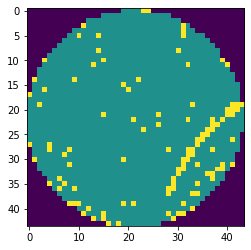

In [29]:
plt.imshow(test_wafermap.iloc[3]["waferMap"])
plt.show()

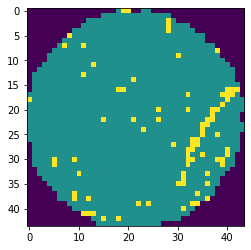

In [30]:
plt.imshow(test_wafermap.iloc[3]["waferMap_augmentation"])
plt.show()

In [31]:
# augmentated data dim
test_wafermap['waferMap_augmentation_Dim']=test_wafermap['waferMap_augmentation'].apply(find_dim)
test_wafermap.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,waferMap_augmentation,waferMap_augmentation_Dim
276745,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2784.0,lot17022,[[Training]],[[Scratch]],"(59, 60)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(59, 60)"
336960,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",912.0,lot20292,[[Training]],[[Scratch]],"(34, 35)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","(34, 35)"
320186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19404,[[Training]],[[Scratch]],"(45, 43)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 43)"
436602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot26411,[[Training]],[[Scratch]],"(44, 44)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(44, 44)"
226776,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14255,[[Training]],[[Scratch]],"(89, 112)",6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(89, 112)"


### wm811k_new_train_class_XXX 만들어서 concat하기
- CNN-WDI input shape 244x244에 맞게 zero-padding 줘야함

In [32]:
# None type class 10,000개 sampling
# 참고 : https://rfriend.tistory.com/602
wm811k_new_train_class_none = wm811k_train.query("failureNum == 8").sample(n=10000, random_state=2022)

In [33]:
wm811k_new_train_class_none.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 749336 to 244652
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        10000 non-null  object 
 1   dieSize         10000 non-null  float64
 2   lotName         10000 non-null  object 
 3   trianTestLabel  10000 non-null  object 
 4   failureType     10000 non-null  object 
 5   waferMapDim     10000 non-null  object 
 6   failureNum      10000 non-null  object 
 7   trainTestNum    10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 703.1+ KB


In [34]:
# Edge-Ring(3) 현 보유 8,554개 / 1,446개 augmentation 필요
# +10도 회전 : 10% - 144개
# -10도 회전 : 10% - 144개
# 좌우 대칭 : 20%  - 288개
# 너비 이동 : 20% - 288개
# 높이 이동: 20% - 288개
# 전단 범위(shearing range) : 10% - 144개
# 확대 : 10% - 150개

In [35]:
# Center(0) 현 보유 3,462개 / 6,538개 augmentation 필요
# +10도 회전 : 10% - 654개
# -10도 회전 : 10% - 654개
# 좌우 대칭 : 20%  - 1308개
# 너비 이동 : 20%  - 1308개
# 높이 이동: 20%   - 1308개
# 전단 범위(shearing range) : 10% - 652개
# 확대 : 10% - 654개

In [36]:
# Edge-Loc(2) 현 보유 2,417개 / 7,583개 augmentation 필요
# +10도 회전 : 10% - 758개
# -10도 회전 : 10% - 758개
# 좌우 대칭 : 20% - 1517개
# 너비 이동 : 20% - 1517개
# 높이 이동: 20%  - 1517개
# 전단 범위(shearing range) : 10% - 758개
# 확대 : 10% - 758개

In [37]:
# Loc(4) 현 보유 1,620개 / 8,380개 augmentation 필요
# +10도 회전 : 10% - 838개
# -10도 회전 : 10% - 838개
# 좌우 대칭 : 20%  - "1676개"
# 너비 이동 : 20%  - "1676개"
# 높이 이동: 20%   - "1676개"
# 전단 범위(shearing range) : 10% - 838개
# 확대 : 10% - 838개

In [38]:
# Random(5) 현 보유 609개 / 9,391개 augmentation 필요
# +10도 회전 : 10%
# -10도 회전 : 10%
# 좌우 대칭 : 20% 
# 너비 이동 : 20%
# 높이 이동: 20%
# 전단 범위(shearing range) : 10%
# 확대 : 10%

In [39]:
# Scratch(6) 현 보유 500개 / 9,500개 augmentation 필요
# +10도 회전 : 10%
# -10도 회전 : 10%
# 좌우 대칭 : 20% 
# 너비 이동 : 20%
# 높이 이동: 20%
# 전단 범위(shearing range) : 10%
# 확대 : 10%

In [40]:
# Donut(1) 현 보유 409개 / 9,591개 augmentation 필요
# +10도 회전 : 10%
# -10도 회전 : 10%
# 좌우 대칭 : 20% 
# 너비 이동 : 20%
# 높이 이동: 20%
# 전단 범위(shearing range) : 10%
# 확대 : 10%

In [41]:
# Near-full(7) 현 보유 54개 / 9,946개 augmentation 필요
# +10도 회전 : 10%
# -10도 회전 : 10%
# 좌우 대칭 : 20% 
# 너비 이동 : 20%
# 높이 이동: 20%
# 전단 범위(shearing range) : 10%
# 확대 : 10%

## CNN-WDI Modeling

- pkl 파일 저장 : https://seing.tistory.com/95